<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Model_LR_RF_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install firebase-admin
#from google.colab import drive 
import firebase_admin
import cv2 
from firebase_admin import credentials,db 
from google.colab.patches import cv2_imshow
from sklearn.externals import joblib 
from firebase_admin import storage 
import pandas as pd 
import csv 
import json
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

In [0]:
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='images_old')

IMAGE GENERATION 

In [0]:
##GETTING NAMES  -- ##Location - SSCB and DTU : Rotated images  

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      #print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)
      
    

In [0]:
##READING THEM 

dtu=[]
sscb=[]
for img in imglenovo:
  if(img[11:16]>'07-02'):##These indicate the DTU Images - which need to be cropped and rotated 
    l=[]
    l.append(img)
    im = cv2.imread(img)
    crop = im[700:3150, 0:3120]
    crop = cv2.resize(crop, (int(np.shape(im)[1]*0.1), int(np.shape(im)[0]*0.1)))
    im = cv2.resize(crop,(256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    dtu.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)           ##These indicate the SSCB Images - rotation only 
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
    l.append(im)
    sscb.append(l)
    
    
    

In [5]:
## CHECKING BLOCK 

print(len(dtu))
print(len(sscb))


369
502


In [0]:
##GETTING NAMES - PUNJABI BAGH 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()
count=0
imgpb = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:  
  if blob.name.split('/')[1]=="rivers.jpg" :
    ctr+=1
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5 and ctr%3==0:
        blob.download_to_filename('/content/' + "pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgpb.append("pb" + str(blob.name.split('/')[-1])+ '.jpeg') 
        #print("pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        count=ctr
        print(count)

In [7]:
print(len(imgpb))

161


In [0]:
##READING IMAGES - Rotated

pb=[]
for img in imgpb:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im, (256,256))
  im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
  l.append(im)
  pb.append(l)


In [0]:
##GETTING NAMES - Location : DTU AND SHADIPUR 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        #print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        print(ctr)
      


In [0]:
##READING IMAGES - Location - SSCB and SHADIPUR ; Rotation 
shadipur = []
for img in imgminote : 
  if(img[11:16]>'07-05'):  ##Shadipur images needed rotating  
    l=[]
    l.append(img)
    im = cv2.imread(img)
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    shadipur.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)               ##SSCB images did not need any rotating 
    im = cv2.resize(im, (256,256))
    l.append(im)
    sscb.append(l)
    

In [11]:
print(len(shadipur))
print(len(sscb))

244
1320


In [0]:


bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imgito = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:17]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
      imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
      #print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)


In [0]:
##READING BLOCK 

ito=[]
count=0

for img in imgito:
  l=[]
  count+=1
  if(count%2==0):
    l.append(img)
    im = cv2.imread(img)
    im = cv2.resize(im,(256,256))
    im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    ito.append(l)


In [140]:

print(np.shape(sscb))    
print(np.shape(ito))      
print(np.shape(dtu))  
print(np.shape(shadipur))     
print(np.shape(pb))   
#print(shanghai.keys())


(1320, 2)
(249, 2)
(369, 2)
(244, 2)
(161, 2)


In [0]:
cred = credentials.Certificate('/content/credentials_new.json')

##  only take the part from where the actual name starts
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'location-5f194.appspot.com',
}, name='images_diff')

In [0]:
## Reading the different locations images -- This includes 

s7_jpeg=[]
note4_jpeg=[]
minote_jpeg=[]
PatelNagarMi_jpeg=[]
gurgaonNote4_jpeg=[]


bucket = storage.bucket(app = app)
blobs = bucket.list_blobs()
ctr=0


## Reading all the LDR images 
for blob in blobs:
  if('s7' in blob.name and 'jpeg' in blob.name and int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5):
      blob.download_to_filename('/content/' + "s7_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg')
      name = "s7_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg' 
      ctr+=1
      im = cv2.imread(name)
      im = cv2.resize(im,(256,256))
      l=[]
      l.append(name)
      l.append(im)
      s7_jpeg.append(l) 
      print(name)
  if('note4' in blob.name and 'jpeg' in blob.name and int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5):
      blob.download_to_filename('/content/' + "note4_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg')
      name = "note4_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg' 
      ctr+=1
      im = cv2.imread(name)
      im = cv2.resize(im,(256,256))
      l=[]
      l.append(name)
      l.append(im)
      note4_jpeg.append(l)
      print(name)
  if('minote' in blob.name and 'jpeg' in blob.name and int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5):
      blob.download_to_filename('/content/' + "minote_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg')
      name = "minote_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg' 
      ctr+=1
      im = cv2.imread(name)
      im = cv2.resize(im,(256,256))
      l=[]
      l.append(name)
      l.append(im)
      minote_jpeg.append(l)
      print(name)
  if('PatelNagarMi' in blob.name and 'jpeg' in blob.name and int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5):
      blob.download_to_filename('/content/' + "PatelNagarMi_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg')
      name = "PatelNagarMi_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg' 
      ctr+=1
      im = cv2.imread(name)
      im = cv2.resize(im,(256,256))
      l=[]
      l.append(name)
      l.append(im)
      PatelNagarMi_jpeg.append(l)
      print(name)
  if('gurgaonNote4' in blob.name and 'jpeg' in blob.name and int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5):
      blob.download_to_filename('/content/' + "gurgaonNote4_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg')
      name = "gurgaonNote4_jpeg" + str(blob.name.split('/')[-1])+ '.jpeg' 
      ctr+=1
      im = cv2.imread(name)
      im = cv2.resize(im,(256,256))
      l=[]
      l.append(name)
      l.append(im)
      gurgaonNote4_jpeg.append(l)
      print(name)


In [139]:

print(len(s7_jpeg))
print(len(note4_jpeg))
print(len(minote_jpeg))
print(len(PatelNagarMi_jpeg))
print(len(gurgaonNote4_jpeg))

94
30
80
539
184


LABEL PROCESSING 

In [0]:
with open('/content/labels_prevhour.bin','rb') as file:
  data = pickle.load(file)

In [0]:
l_s7_jpeg=data['s7_jpeg']
l_note4_jpeg=data['note4_jpeg']
l_minote_jpeg=data['minote_jpeg']
l_PatelNagarMi_jpeg=data['PatelNagarMi_jpeg']
l_gurgaonNote4_jpeg=data['gurgaonNote4_jpeg']

In [0]:
feat=[]


for img in s7_jpeg:
  #print(img[0][7:])
  for l  in l_s7_jpeg:
    #print(l[0])
    if(img[0][7:] == l[0]):
      print('s7')
      t=[]
      im = img[1]
      t.append(l[0])
      t.append(entropy(im))
      t.append(contrast(im))
      t.append(trans_deg(img[1]))
      t.append(l[1])
      t.append(l[2]) ##--> prev hours reading 
      feat.append(t)

for img in note4_jpeg:
  #print(img[0][10:])
  for l in l_note4_jpeg:
    #print(l[0])
    if(img[0][10:] == l[0]):
      print('note4')
      t=[]
      im = img[1]
      t.append(l[0])
      t.append(entropy(im))
      t.append(contrast(im))
      t.append(trans_deg(img[1]))
      t.append(l[1])
      t.append(l[2]) ##--> prev hours reading 
      feat.append(t) 
  
for img in minote_jpeg:  
  for l in l_minote_jpeg:
    if(img[0][11:] == l[0]):
      print('minote')
      t=[]
      im = img[1]
      t.append(l[0])
      t.append(entropy(im))
      t.append(contrast(im))
      t.append(trans_deg(img[1]))
      t.append(l[1])
      t.append(l[2]) ##--> prev hours reading 
      feat.append(t)

for img in PatelNagarMi_jpeg:
  #print(img[0][17:])
  for l  in l_PatelNagarMi_jpeg:
    #print(l[0])
    if(img[0][17:] == l[0]):
      print('PatelNagar')
      t=[]
      im = img[1]
      t.append(l[0])
      t.append(entropy(im))
      t.append(contrast(im))
      t.append(trans_deg(img[1]))
      t.append(l[1])
      t.append(l[2]) ##--> prev hours reading 
      feat.append(t) 

for img in gurgaonNote4_jpeg:
  #print(img[0][17:])
  for l  in l_gurgaonNote4_jpeg:
    #print(l[0])
    if(img[0][17:] == l[0]):
      print('Gurgaon')
      t=[]
      im = img[1]
      t.append(l[0])
      t.append(entropy(im))
      t.append(contrast(im))
      t.append(trans_deg(img[1]))
      t.append(l[1])
      t.append(l[2]) ##--> prev hours reading 
      feat.append(t) 
    


s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
s7
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
note4
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote
minote

In [0]:
print(len(feat))

In [0]:
cred = credentials.Certificate('/content/credentials_weather.json')

##The weather data after 1st July 

# Initialize the app with a service account, granting admin privileges
new = firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://celestini-bd493.firebaseio.com/'
}, name ='w')

In [0]:
    
ref = db.reference(app=new)
df = ref.get()


In [0]:
temp_weather = {}

for key in df:
  try:
    l=[]
    l.append(df[key]['main']['humidity'])
    l.append(df[key]['main']['pressure'])
    l.append(df[key]['main']['temp'])
    l.append(df[key]['visibility'])
    l.append(df[key]['wind']['deg'])
    l.append(df[key]['wind']['speed'])
    l.append(df[key]['clouds']['all'])
    k = df[key]['weather'][0]['description']
    if(k=='haze'):
      l.append(0)
    elif(k=='mist'):
      l.append(1)
    elif(k=='drizzle'):
      l.append(2)
    elif(k=='dust'):
      l.append(3)
    temp_weather[key]=l
  except:
    print(key)
    

In [0]:
feat_a=[]
for val in feat:
  #print(val[0])
  temp = val[0] 
  #print(temp)
  temp=temp.split('-')
  #print(temp)
  newtemp=temp[2].split(' ')
  #print(newtemp)
  newesttemp=newtemp[1].split(':')
  #print(newesttemp)
  j=int(newesttemp[1])
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l=[]
  l.append(final)
  l.append(val[1])
  l.append(val[2])
  l.append(val[3])
  l.append(val[4])
  l.append(val[5]) #The previous hours reading 
  feat_a.append(l)


In [0]:
print(len(feat_a))

In [0]:
print(feat_a[0])

In [0]:
weather={}
for key in temp_weather:
  temp=key.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  if(j<=7.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  if(final not in weather):
    weather[final]=temp_weather[key]

In [0]:
trans=[]
cont=[]
ent=[]
hours=[]
hum=[]
pressure=[]
tempr=[]
deg=[]
speed=[]
prev=[]
pm=[]

## COMBINING 1ST 4 LOCATIONS DATA 
for e in feat_a:
  #index+=1
  for w in weather:
    if(e[0] == w):
      #c=0
      hours.append(float(e[0][-5:-3]))
      
#       while(int(feat_a[index][0][-5:-3])!=(int(e[0][-5:-3])-1) and c<6):
#           index-=1
#       prev.append(float(feat_a[index][4]))
      
      pm.append(float(e[4]))
      prev.append(float(e[5]))
      trans.append(e[3])
      ent.append(float(e[1]))
      cont.append(float(e[2]))
      hum.append(float(weather[w][0]))
      pressure.append(float(weather[w][1]))
      tempr.append(float(weather[w][2])) 
      deg.append(float(weather[w][4]))
      speed.append(float(weather[w][5]))
    

In [0]:
print(len(trans))
print(len(hours))
print(len(cont))
print(len(ent))
print(len(hum))
print(len(pressure))
print(len(tempr))
print(len(deg))
print(len(speed))
print(len(pm))
print(len(prev))

In [0]:
print(trans)
print(hours)
print(cont)
print(ent)
print(hum)
print(pressure)
print(tempr)
print(deg)
print(speed)
print(pm)
print(prev)

In [0]:
##SSCB 
df = pd.read_csv('/content/sscb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/sscb_labels_new.csv')

k=0
cpcb=[]
val = '61'
with open('/content/sscb_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      l.append(val)
      if(k%5==0):
        val=row[3]
      cpcb.append(l) 

In [0]:
print(cpcb)

In [0]:
##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in sscb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  
  

In [0]:
feat=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      im = date[2]
      imc = date[2]
      imc = cv2.resize(imc, (64,64))
      l=[]
      l.append(val[0])
      #l.append(np.ndarray.flatten(transmission(imc)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      l.append(val[2])
      l.append(trans_deg(im))
      #print('   -   -  ' + str(l))
      feat.append(l)
   

In [0]:
print(feat)

In [0]:

df = pd.read_csv('/content/dtu_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/dtu_labels_new.csv')
k=0

cpcb=[]



val ='46.11'
with open('/content/dtu_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      l.append(val)
      if(k%5==0):
        val=row[3]
      cpcb.append(l) 

In [0]:
print(cpcb)

In [0]:
##TIMESTAMP MODIFICATION 


m_tmp=[]
for tmp in dtu:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  

In [0]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      im = date[2]
      l=[]
#       imc = date[2]
#       imc = cv2.resize(imc, (64,64))
      l.append(val[0])
      #l.append(np.ndarray.flatten(transmission(im)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      l.append(val[2])
      l.append(trans_deg(im))
      #print('   -   -  ' + str(l))
      feat.append(l)
      

In [0]:

# PUNJABI BAGH 

df = pd.read_csv('/content/pb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/labels_pb_new.csv')


k=0
cpcb=[]
val ='54.4'
with open('/content/labels_pb_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      l.append(val)
      if(k%5==0):
        val=row[3]
      cpcb.append(l) 

In [0]:
print(cpcb)

In [0]:
##TIMESTAMP MODIFICATION 

m_tmp=[]
for tmp in pb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)   

In [0]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      l.append(val[2])
      l.append(trans_deg(im))
      #print('   -   -  ' + str(l))
      feat.append(l)

In [0]:

print(feat)

In [0]:


## SHADIPUR 

df_ = pd.read_csv('/content/shadipur_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/shadipur_labels_new.csv')


k=0
cpcb=[]
val ='67.11 '
with open('/content/shadipur_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      l.append(val)
      if(k%5==0):
        val=row[3]
      cpcb.append(l) 

In [0]:

##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in shadipur:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) 
 

In [0]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      #l.append(np.ndarray.flatten(transmission(im)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      l.append(val[2])
      l.append(trans_deg(im))
      #print('   -   -  ' +str(l))
      feat.append(l)

In [0]:
# ITO 
df_ = pd.read_csv('/content/ito_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/ito_labels_new.csv')


k=0
cpcb=[]
val ='104 '
with open('/content/ito_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      l.append(val)
      if(k%5==0):
        val=row[3]
      cpcb.append(l) 

In [0]:
print(cpcb)

In [0]:
#TIMESTAMP MODIFICATION 
m_tmp=[]
for t in ito:
  l=[]
  temp=t[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(t[0])
  l.append(final)
  l.append(t[1])
  m_tmp.append(l) 

In [0]:
ito_tomatch=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      #l.append(np.ndarray.flatten(transmission(im)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      l.append(val[2])
      l.append(trans_deg(im))
      ito_tomatch.append(l)

In [0]:
print(len(feat))

WEATHER DATA 

In [0]:
cred = credentials.Certificate('credentials.json')

# Initialize the app with a service account, granting admin privileges
ito_n = firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://fir-4ca2c.firebaseio.com/'
},name = 'w_ito_n')

In [0]:
    
ref = db.reference(app=ito_n)
df = ref.get()


In [0]:
temp_weather = {}

for key in df:
  try:
    l=[]
    l.append(df[key]['main']['humidity'])
    l.append(df[key]['main']['pressure'])
    l.append(df[key]['main']['temp'])
    l.append(df[key]['visibility'])
    l.append(df[key]['wind']['deg'])
    l.append(df[key]['wind']['speed'])
    l.append(df[key]['clouds']['all'])
    k = df[key]['weather'][0]['description']
    if(k=='haze'):
      l.append(0)
    elif(k=='mist'):
      l.append(1)
    elif(k=='drizzle'):
      l.append(2)
    elif(k=='dust'):
      l.append(3)
    temp_weather[key]=l
  except:
    print(key)

In [0]:
## COMBINING ITO DATA 

with open('/content/past-weather (1).json') as file:
  data = json.load(file)
  source = data['data']['weather']


In [0]:
## MATCHING ITO DATA 

hour_i=[]
pres_i=[]
temp_i=[]
deg_i=[]
speed_i=[]

ito_weather=[]

with open('/content/past-weather (1).json') as file:
  data = json.load(file)
  source = data['data']['weather']
  
  for i in source:
    for j in range(0,24):
      date = i['date']
      date = date.split(' ')
      date = date[0]
      t = date.split('-')
      t = t[2]+'-'+t[1]+'-'+t[0]
      if(len(str(j))==1):
        key = t + ' ' + '0' +str(j) + ':00' 
      else:
        key = t + ' ' +str(j) + ':00'
      l=[]
      l.append(key)
      l.append(i['hourly'][j]['humidity'])
      l.append(i['hourly'][j]['tempC'])
      l.append(i['hourly'][j]['windspeedKmph'])
      l.append(i['hourly'][j]['winddirDegree'])
      l.append(i['hourly'][j]['pressure'])
      ito_weather.append(l)
     

In [0]:

print(len(ito_weather))

In [0]:
weather={}
for key in temp_weather:
  temp=key.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  if(j<=7.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  if(final not in weather):
    weather[final]=temp_weather[key]
  
  

In [0]:
print(len(weather))

In [0]:
print(len(feat))

In [0]:
print(feat[0])

In [0]:

## COMBINING 1ST 4 LOCATIONS DATA 
for e in feat:
  for w in weather:                             
    if(e[0] == w):
      hours.append(float(e[0][-5:-3]))
      pm.append(float(e[3]))
      trans.append(e[5])
      prev.append(e[4])
      ent.append(float(e[1]))
      cont.append(float(e[2]))
      hum.append(float(weather[w][0]))
      pressure.append(float(weather[w][1]))
      tempr.append(float(weather[w][2])) 
      deg.append(float(weather[w][4]))
      speed.append(float(weather[w][5]))


In [0]:
print(len(hours))

In [0]:
print(ito_tomatch)

In [0]:

for e in ito_tomatch:
  for w in ito_weather: 
    if(e[0] == w[0]):
      hours.append(e[0][-5:-3])
      trans.append(e[5])
      prev.append(e[4])
      ent.append(e[1])
      cont.append(e[2])
      pm.append(e[3])
      hum.append(w[1])
      tempr.append(w[2])
      speed.append(w[3]) 
      deg.append(w[4])
      pressure.append(w[5])

  

In [0]:
print(len(trans))
print(len(hours))
print(len(cont))
print(len(ent))
print(len(hum))
print(len(pressure))
print(len(tempr))
print(len(deg))
print(len(speed))
print(len(prev))

In [0]:
prev = list(map(float,prev))

In [137]:
print(trans)
print(hours)
print(cont)
print(ent)
print(hum)
print(pressure)
print(tempr)
print(deg)
print(speed)
print(pm)


[1, 1, 1, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 3, 1, 3, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 5, 0.9959810172352763, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

POINT TO CONCATENATE ALL THE NEW DATA - USE NON SCALED FEATURES OF ALL THE DATA 

In [0]:
with open('/content/Non_Scaled_June_July_Aug.bin','rb') as file:
  f1 = pickle.load(file)
with open('/content/Labels_June_July_Aug.bin','rb') as file:
  l1 = pickle.load(file)
with open('/content/NOVEMBER_non_scaled_features_withshadipur.bin','rb') as file:
  f2 = pickle.load(file)
with open('/content/labels_November_withshadipur.bin','rb') as file:
  l2 = pickle.load(file)

In [87]:
print(np.shape(f1))
print(np.shape(l1))
print(np.shape(f2))
print(np.shape(l2))

(2471, 10)
(2471, 10)
(356, 10)
(356, 1)


In [138]:
print(np.shape(hours))

(541,)


In [0]:
final_shape=len(hours)

#FEATURES 

trans= np.reshape(trans,(final_shape,1))
hours = np.reshape(hours,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
hum = np.reshape(hum,(final_shape,1))
pressure = np.reshape(pressure,(final_shape,1))
tempr = np.reshape(tempr,(final_shape,1))
deg = np.reshape(deg,(final_shape,1))
speed = np.reshape(speed,(final_shape,1))
prev = np.reshape(prev,(final_shape,1))


features = np.hstack((hours, cont, ent , hum, tempr, deg, speed, pressure,trans,prev))

print(max(hours))
print(min(hours))


print(max(cont))
print(min(cont))


print(max(ent))
print(min(ent))


print(max(hum))
print(min(hum))


print(max(tempr))
print(min(tempr))


print(max(deg))
print(min(deg))


print(max(speed))
print(min(speed))


print(max(pressure))
print(min(pressure))


print(max(trans))
print(min(trans))

print(max(prev))
print(min(prev))

with open('/content/Non_Scaled_June_July_Aug.bin','wb') as file:
  pickle.dump(features, file)


pm = np.reshape(pm,(final_shape,1))


##SCALING 

s1 = MinMaxScaler()
hours = s1.fit_transform(hours)
s2 = MinMaxScaler()
cont = s2.fit_transform(cont)
s3 = MinMaxScaler()
ent = s3.fit_transform(ent)
s4 = MinMaxScaler()
hum = s4.fit_transform(hum)
s5 = MinMaxScaler()
pressure = s5.fit_transform(pressure)
s6 = MinMaxScaler()
tempr = s6.fit_transform(tempr)
s7 = MinMaxScaler()
deg = s7.fit_transform(deg)
s8 = MinMaxScaler()
speed = s8.fit_transform(speed)
s9 = MinMaxScaler()
prev = s9.fit_transform(prev)




with open('/content/S1.bin','wb') as file:
  pickle.dump(s1,file)
with open('/content/S2.bin','wb') as file:
  pickle.dump(s2,file)
with open('/content/S3.bin','wb') as file:
  pickle.dump(s3,file)
with open('/content/S4.bin','wb') as file:
  pickle.dump(s4,file)
with open('/content/S5.bin','wb') as file:
  pickle.dump(s5,file)
with open('/content/S6.bin','wb') as file:
  pickle.dump(s6,file)
with open('/content/S7.bin','wb') as file:
  pickle.dump(s7,file)
with open('/content/S8.bin','wb') as file:
  pickle.dump(s8,file)
  
features = np.hstack((hours, cont, ent , hum, tempr, deg, speed, pressure,trans,prev))


with open('/content/Scaled_June_July_Aug.bin','wb') as file:
  pickle.dump(features, file)


with open('/content/Labels_June_July_Aug.bin','wb') as file:
  pickle.dump(pm, file)



In [0]:
with open('/content/Non_Scaled_June_July_Aug.bin','rb') as file:
  data = pickle.load(file)
  
  


In [88]:
print(np.shape(pm))

(2471, 1)


In [0]:
print(type(trans))
print(type(hours))
print(type(cont))
print(type(ent))
print(type(hum))
print(type(pressure))
print(type(tempr))
print(type(deg))
print(type(speed))
print(type(prev))

INCLUDING NOVEMBER DATA 

In [0]:
with open('/content/features_November_w.bin','rb') as file:
    nov_f = pickle.load(file)

with open('/content/labels_November_w.bin','rb') as file:
    nov_l = pickle.load(file)

In [0]:
print(features)

[[0.33333333 0.14261257 0.30079014 ... 0.81818182 1.         0.20111732]
 [0.33333333 0.13209703 0.29103081 ... 0.81818182 1.         0.20111732]
 [0.41666667 0.77718964 0.66622735 ... 0.81818182 1.         0.20111732]
 ...
 [0.66666667 0.65664912 0.80258119 ... 0.36363636 2.         0.09497207]
 [0.75       0.64366259 0.79403046 ... 0.27272727 2.         0.10055866]
 [0.83333333 0.63186524 0.89162179 ... 0.27272727 2.         0.10055866]]


In [0]:
print(nov_f)

[[0.         0.9929962  0.75184617 ... 0.33333333 1.         1.        ]
 [0.         1.         0.75691279 ... 0.33333333 1.         1.        ]
 [0.1        0.89421312 0.90078112 ... 0.66666667 1.         1.        ]
 ...
 [0.9        0.6243114  0.42114606 ... 0.         4.         0.        ]
 [0.9        0.62568304 0.42620236 ... 0.         4.         0.        ]
 [1.         0.68680941 0.40493424 ... 0.         4.         0.02212389]]


In [0]:
final_features = np.vstack((features,nov_f))
print(len(final_features))

2753


In [0]:
final_pm = np.vstack((pm,nov_l))

In [0]:
print(len(final_pm))

2753


In [0]:
with open('/content/featuresFinal_withNOV.bin','wb') as file:
  pickle.dump(final_features,file)
with open('/content/labelsFinal_withNOV.bin','wb') as file:
  pickle.dump(final_pm,file)

In [0]:
print(type(final_features))
print(type(final_pm))
print(len(final_features))
print(len(final_pm))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2753
2753


In [0]:
final_features = list(map(np.float32,final_features))
final_pm = list(map(np.float32,final_pm))

46.2986


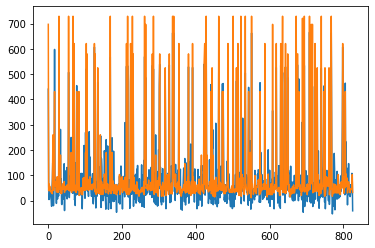

In [0]:
lineareg = LinearRegression(normalize =False)
cross = cross_val_score(lineareg, final_features,final_pm, scoring ='neg_mean_absolute_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(final_features, final_pm, test_size =0.3, random_state =42)
lineareg.fit(x_train, y_train)
pred = lineareg.predict(x_test)
plt.plot(pred)
plt.plot(y_test)
print(mean_absolute_error(pred, y_test))


In [0]:
with open('/content/LR_prevpm.bin','wb') as file:
  pickle.dump(lineareg,file)



In [0]:
print(((-1)*cross))

[ 84.44548798  41.00475693 171.53143311]


In [0]:
d=[]
for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  k=y_test[i]-pred[i]
  if(k>=20):
    d.append(k)


[697.]	[440.60077]
[39.]	[56.08667]
[65.55]	[3.9496994]
[61.]	[25.536259]
[46.68]	[16.369545]
[53.45]	[52.24951]
[35.]	[35.979145]
[40.]	[9.744171]
[35.]	[0.39925385]
[31.09]	[-22.951439]
[28.6]	[49.29493]
[27.]	[77.75383]
[180.]	[148.2232]
[260.]	[105.83392]
[40.84]	[-20.524635]
[40.]	[35.12015]
[260.]	[118.58257]
[431.]	[597.78107]
[63.]	[96.388275]
[57.]	[53.220207]
[73.]	[82.39104]
[44.]	[50.552345]
[34.16]	[-11.384201]
[39.]	[67.29953]
[94.]	[76.51827]
[32.81]	[6.20829]
[56.85]	[30.962776]
[46.]	[30.589462]
[32.81]	[18.4006]
[729.]	[504.4531]
[44.]	[72.465706]
[74.]	[162.1311]
[44.]	[31.692978]
[180.]	[281.3882]
[29.]	[36.29456]
[44.]	[85.47189]
[27.]	[-13.696571]
[41.]	[-15.966911]
[56.]	[16.986275]
[66.]	[49.220474]
[48.]	[24.01986]
[44.67]	[5.678154]
[57.]	[101.683205]
[75.]	[145.55807]
[31.93]	[-39.650536]
[50.]	[117.994415]
[54.78]	[27.371208]
[42.2]	[105.03793]
[41.]	[18.75579]
[56.]	[61.71261]
[61.]	[130.69226]
[60.88]	[6.4433517]
[44.]	[76.21222]
[44.8]	[68.543076]
[48.]	[

In [0]:
#plt.plot(d)

##26% of our test data is more than 10 deviations 
print(len(y_test))
print(len(d))

826
319


In [0]:
d=[]

#20% is out of bounds by 15 

for i in range(0,len(pred)):
  k=y_test[i]-pred[i]
  if(k>=15):
    d.append(k)


In [0]:
print(len(y_test))
print(len(d))

826
361


RANDOM FOREST REGRESSOR 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_trai

15.593219494028316


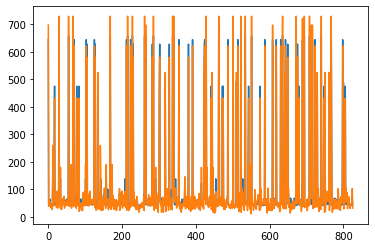

In [0]:
reg = RandomForestRegressor(max_depth=3) 
cross = cross_val_score(reg, final_features, final_pm, scoring ='neg_mean_absolute_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(final_features, final_pm, test_size =0.3, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_absolute_error(pred, y_test))


In [0]:
print(((-1)*cross))

[ 48.12147474   9.09014059 156.23653237]


In [0]:
#joblib.dump(reg,'Random_withITO.pkl')
with open('/content/RF_withPrevPM.bin','wb') as file:
  pickle.dump(reg, file)



In [0]:

for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  
  

In [0]:
def trans_deg(im):
#   im = cv2.imread(img)
#   im = cv2.resize(im, (256,256))
  B=np.zeros((256,256))
  D=np.zeros((256,256))
  C=np.zeros((256,256))
  # 3rd channel or im[2] has been split as b,g,r 

  b,g,r = cv2.split(im)

  for i in range(b.shape[0]):
    for j in range(b.shape[1]):
      D[i][j] = min(b[i][j], g[i][j], r[i][j])
      B[i][j] = max(b[i][j], g[i][j], r[i][j])
      C[i][j] = B[i][j] - D[i][j]

  d = np.sum(D)/float(np.size(D))
  b = np.sum(B)/float(np.size(B))
  c = b-d 
  A = (0.33)*max(np.ndarray.flatten(B)) + (0.66)*b
  
  x1=((A - d)/float(A)) 
  x2=(c/float(A))
  u = 10.127489
  v= -8.336512
  s = 0.13606234
  
  w = math.exp(-0.5*(u*x1 + v*x2)+s)
  
  if(w<=0.1):
      w=0
  elif(w<=0.3):
    w=1
  elif(w<=0.5):
    w=2
  elif(w<=0.7):
    w=3
  elif(w<=0.8):
    w=4
  elif(w<=0.9):
    w=5
    
  return w

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
# from sklearn.ensemble import GradientBoostingRegressor

# gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)

# cross = cross_val_score(gbrt, features, pm, scoring ='neg_mean_squared_error',cv=3)

# x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

# gbrt.fit(x_train, y_train)

# y_pred = gbrt.predict(x_test)

# errors = [mean_squared_error(y_val, y_pred)
# for y_pred in gbrt.staged_predict(X_val)]

# bst_n_estimators = np.argmin(errors)

# gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
# gbrt_best.fit(x_train, y_train) 


In [0]:
# print((cross*(-1))**0.5)

In [0]:
# pred = gbrt_best.predict(x_test)

# plt.plot(pred)
# plt.plot(y_test)

# print(mean_squared_error(pred, y_test)**0.5)

In [0]:
# pred = reg.predict(x_test)

# plt.plot(pred)
# plt.plot(y_test)

# print(mean_squared_error(pred, y_test)**0.5)

In [0]:
# print(((-1)*cross)**0.5)